https://keras.io/examples/audio/ctc_asr/

We will evaluate the quality of the model using Word Error Rate (WER). WER is obtained by adding up the substitutions, insertions, and deletions that occur in a sequence of recognized words. Divide that number by the total number of words originally spoken. The result is the WER. To get the WER score you need to install the jiwer package. You can use the following command line:<br>
```shell
pip install jiwer
```

References:

- LJSpeech Dataset
- Speech recognition
- Sequence Modeling With CTC
- DeepSpeech2

## SetUp

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from IPython import display
from jiwer import wer

## Load the LJSpeech Dataset
By default the file at the url origin is downloaded to the cache_dir ~/.keras, placed in the cache_subdir datasets, and given the filename fname. The final location of a file example.txt would therefore be ~/.keras/datasets/example.txt.
Como ya lo descargué una vez, he actualizado la ruta donde se descargó.

In [2]:
#data_url = "https://data.keithito.com/data/speech/LJSpeech-1.1.tar.bz2"
#data_path = keras.utils.get_file("LJSpeech-1.1", data_url, untar=True)
data_path ="/home/data/.keras/datasets/LJSpeech-1.1"
wavs_path = data_path + "/wavs/"
metadata_path = data_path + "/metadata.csv"


# Read metadata file and parse it
metadata_df = pd.read_csv(metadata_path, sep="|", header=None, quoting=3)
metadata_df.columns = ["file_name", "transcription", "normalized_transcription"]
metadata_df = metadata_df[["file_name", "normalized_transcription"]]
metadata_df = metadata_df.sample(frac=1).reset_index(drop=True)
metadata_df.head(3)

,file_name,normalized_transcription
0,LJ028-0063,Then Syria and Palestine were added to his fut...
1,LJ019-0353,they were at liberty to hire suitable cell acc...
2,LJ022-0057,The program for social security now pending be...


#### comprobaciones

In [3]:
print(data_path)
print(wavs_path)
print(metadata_path)
print(metadata_df.shape)

/home/data/.keras/datasets/LJSpeech-1.1
/home/data/.keras/datasets/LJSpeech-1.1/wavs/
/home/data/.keras/datasets/LJSpeech-1.1/metadata.csv
(13100, 2)


## Split data into trainning and validation set

In [4]:
split = int(len(metadata_df) * 0.90)
df_train = metadata_df[:split]
df_val = metadata_df[split:]

print(f"Size of the training set: {len(df_train)}")
print(f"Size of the training set: {len(df_val)}")

Size of the training set: 11790
Size of the training set: 1310


## Preprocessing

### Prepare the vocabulary

In [5]:
# The set of characters accepted in the transcription.
characters = [x for x in "abcdefghijklmnopqrstuvwxyz'?! "]
# Mapping characters to integers
char_to_num = keras.layers.StringLookup(vocabulary=characters, oov_token="")
# Mapping integers back to original characters
num_to_char = keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', ' '] (size =31)


#### Comprobaciones. Pdte de trabajar con tensores

In [6]:
print(type(char_to_num))

<class 'keras.src.layers.preprocessing.string_lookup.StringLookup'>


In [7]:
# print(dir(keras.layers.StringLookup)) # He intentado buscar los metodos de la clase
msg = np.str_(['hola'])
msg_num = char_to_num([msg])
print(char_to_num([msg]))


tf.Tensor([0], shape=(1,), dtype=int64)


### Prepare a function to apply to each element of the dataset

In [9]:
frame_length = 256
# An integer scalar Tensor. The number of samples to step.
frame_step = 160
# An integer scalar Tensor. The size of the FFT to apply.
# If not provided, uses the smallest power of 2 enclosing frame_length.
fft_length = 384


def encode_single_sample(wav_file, label):
    ###########################################
    ##  Process the Audio
    ##########################################
    # 1. Read wav file
    file = tf.io.read_file(wavs_path + wav_file + ".wav")
    # 2. Decode the wav file
    audio, _ = tf.audio.decode_wav(file)
    audio = tf.squeeze(audio, axis=-1)
    # 3. Change type to float
    audio = tf.cast(audio, tf.float32)
    # 4. Get the spectrogram
    spectrogram = tf.signal.stft(
        audio, frame_length=frame_length, frame_step=frame_step, fft_length=fft_length
    )
    # 5. We only need the magnitude, which can be derived by applying tf.abs
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.math.pow(spectrogram, 0.5)
    # 6. normalisation
    means = tf.math.reduce_mean(spectrogram, 1, keepdims=True)
    stddevs = tf.math.reduce_std(spectrogram, 1, keepdims=True)
    spectrogram = (spectrogram - means) / (stddevs + 1e-10)
    
    ###########################################
    ##  Process the label
    ##########################################
    # 7. Convert label to Lower case
    label = tf.strings.lower(label)
    # 8. Split the label
    label = tf.strings.unicode_split(label, input_encoding="UTF-8")
    # 9. Map the characters in label to numbers
    label = char_to_num(label)
    # 10. Return a dict as our model is expecting two inputs
    return spectrogram, label

## Creating Dataset objects

In [10]:
batch_size = 32
# Define the training dataset
train_dataset = tf.data.Dataset.from_tensor_slices(
    (list(df_train["file_name"]), list(df_train["normalized_transcription"]))
)
train_dataset = (
    train_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
    .padded_batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

# Define the validation dataset
validation_dataset = tf.data.Dataset.from_tensor_slices(
    (list(df_val["file_name"]), list(df_val["normalized_transcription"]))
)
validation_dataset = (
    validation_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
    .padded_batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

### Visualize the data

2023-08-12 19:48:25.620637: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 33671552 exceeds 10% of free system memory.


spectograma: <class 'numpy.ndarray'>
spectograma_size: (1363, 193)


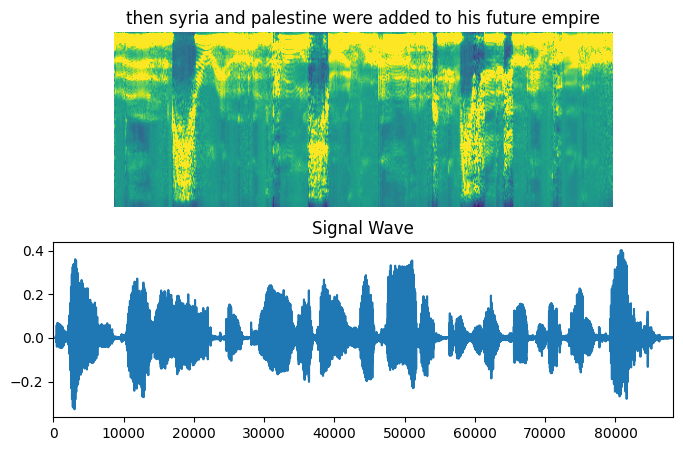

In [16]:
fig = plt.figure(figsize=(8, 5))
for batch in train_dataset.take(1):
    
    spectrogram = batch[0][0].numpy()
    print(f"spectograma: {type(spectrogram)}")
    print(f"spectograma_size: {spectrogram.shape}")
    spectrogram = np.array([np.trim_zeros(x) for x in np.transpose(spectrogram)])
    label = batch[1][0]
    # Spectrogram
    label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
    ax = plt.subplot(2, 1, 1)
    ax.imshow(spectrogram, vmax=1)
    ax.set_title(label)
    ax.axis("off")
    # Wav
    file = tf.io.read_file(wavs_path + list(df_train["file_name"])[0] + ".wav")
    audio, _ = tf.audio.decode_wav(file)
    audio = audio.numpy()
    ax = plt.subplot(2, 1, 2)
    plt.plot(audio)
    ax.set_title("Signal Wave")
    ax.set_xlim(0, len(audio))
    display.display(display.Audio(np.transpose(audio), rate=16000))
plt.show()

## MODEL

### Loss Function

In [17]:
def CTCLoss(y_true, y_pred):
    # Compute the training-time loss value
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

### Neuronal Network model

In [20]:
# librerías que utiliza el de 'github'
from keras import backend as K
from keras.models import Model
from keras.layers import (BatchNormalization, Conv1D, Dense, Input, 
    TimeDistributed, Activation, Bidirectional, SimpleRNN, GRU, LSTM)

def build_model(input_dim, output_dim):
    """Model similar 1_simple"""
    # Model's input
    input_spectrogram = layers.Input((None, input_dim), name="input")
    # Expand the dimension to use 2D CNN.
    #x = layers.Reshape((-1, input_dim, 1), name="expand_dim")(input_spectrogram)
    # Add recurrent layer
    simple_rnn = GRU(output_dim, return_sequences=True, 
                 implementation=2, name='rnn')(input_spectrogram)

    
    # Classification layer
    output = layers.Dense(units=output_dim + 1, activation="softmax")(simple_rnn)
    # Model
    model = keras.Model(input_spectrogram, output, name="SimpleRNN_GRU")
    # Optimizer
    opt = keras.optimizers.Adam(learning_rate=1e-4)
    # Compile the model and return
    model.compile(optimizer=opt, loss=CTCLoss)
    return model


# Get the model
model = build_model(
    input_dim=fft_length // 2 + 1,
    output_dim=char_to_num.vocabulary_size(),
)
model.summary(line_length=110)

Model: "SimpleRNN_GRU"
______________________________________________________________________________________________________________
 Layer (type)                                    Output Shape                                Param #          
 input (InputLayer)                              [(None, None, 193)]                         0                
                                                                                                              
 rnn (GRU)                                       (None, None, 31)                            21018            
                                                                                                              
 dense_1 (Dense)                                 (None, None, 32)                            1024             
                                                                                                              
Total params: 22042 (86.10 KB)
Trainable params: 22042 (86.10 KB)
Non-trainable params: 0

## TRAINING AND EVALUATING

In [21]:
# A utility function to decode the output of the network
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0]
    # Iterate over the results and get back the text
    output_text = []
    for result in results:
        result = tf.strings.reduce_join(num_to_char(result)).numpy().decode("utf-8")
        output_text.append(result)
    return output_text


# A callback class to output a few transcriptions during training
class CallbackEval(keras.callbacks.Callback):
    """Displays a batch of outputs after every epoch."""

    def __init__(self, dataset):
        super().__init__()
        self.dataset = dataset

    def on_epoch_end(self, epoch: int, logs=None):
        predictions = []
        targets = []
        for batch in self.dataset:
            X, y = batch
            batch_predictions = model.predict(X)
            batch_predictions = decode_batch_predictions(batch_predictions)
            predictions.extend(batch_predictions)
            for label in y:
                label = (
                    tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
                )
                targets.append(label)
        wer_score = wer(targets, predictions)
        print("-" * 100)
        print(f"Word Error Rate: {wer_score:.4f}")
        print("-" * 100)
        for i in np.random.randint(0, len(predictions), 2):
            print(f"Target    : {targets[i]}")
            print(f"Prediction: {predictions[i]}")
            print("-" * 100)

Start training process

In [22]:
# Define the number of epochs.
epochs = 1
# Callback function to check transcription on the val set.
validation_callback = CallbackEval(validation_dataset)
# Train the model
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    callbacks=[validation_callback],
)

1/1 [==============================] - 3s 3s/step
----------------------------------------------------------------------------------------------------
Word Error Rate: 0.9999
----------------------------------------------------------------------------------------------------
Target    : weighted by treble the amount of costs
Prediction: n
----------------------------------------------------------------------------------------------------
Target    : this was done in the case of the nationalist party of puerto rico for example but only after members of the group had resorted to political violence
Prediction: nn
----------------------------------------------------------------------------------------------------
369/369 [==============================] - 3853s 10s/step - loss: 2178.3022 - val_loss: 1513.2238


In [24]:
print("ha acabado")


ha acabado


## Inference

In [25]:
#Let's check results on more validation samples
predictions = []
targets = []
for batch in validation_dataset:
    X, y = batch
    batch_predictions = model.predict(X)
    batch_predictions = decode_batch_predictions(batch_predictions)
    predictions.extend(batch_predictions)
    for label in y:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        targets.append(label)
wer_score = wer(targets, predictions)
print("-" * 100)
print(f"Word Error Rate: {wer_score:.4f}")
print("-" * 100)
for i in np.random.randint(0, len(predictions), 5):
    print(f"Target    : {targets[i]}")
    print(f"Prediction: {predictions[i]}")
    print("-" * 100)

1/1 [==============================] - 1s 534ms/step
----------------------------------------------------------------------------------------------------
Word Error Rate: 0.9999
----------------------------------------------------------------------------------------------------
Target    : the other perpetrated in a railwaycarriage and showing the promptitude with which criminals accept and utilize altered conditions of life
Prediction: n
----------------------------------------------------------------------------------------------------
Target    : hanging in chains upon the gibbet which had served for the execution
Prediction: njn
----------------------------------------------------------------------------------------------------
Target    : as the law stood since the passing of the ninth george the fourth c forty any two justices might remove a prisoner found to be insane either on commitment
Prediction: nn
----------------------------------------------------------------------------